# Análisis de Serie Temporal - Consumo e Importación de Diésel

Este notebook documenta el análisis de la serie temporal del consumo e importación de diésel, cubriendo las etapas requeridas en el laboratorio:

- Análisis exploratorio.
- Serie univariante.
- Descomposición y evaluación de componentes.
- Estacionariedad y transformación.
- Modelado ARIMA y Prophet.
- Comparación y selección del mejor modelo.

## Consolidación de Subcategorías de Diésel

Agrupamos las siguientes columnas:

- Diesel alto azufre
- Diesel bajo azufre
- Diesel ultra bajo azufre

En una sola columna llamada `Diesel`.

In [7]:
import pandas as pd

# Cargar datos
df_import = pd.read_csv('../data/importacion.csv', parse_dates=['Fecha'])
df_cons = pd.read_csv('../data/consumo.csv', parse_dates=['Fecha'])

# Combinar columnas de diésel
diesel_cols = ['Diesel alto azufre', 'Diesel bajo azufre', 'Diesel ultra bajo azufre']

# Verificar columnas
for col in diesel_cols:
    if col not in df_import.columns:
        print(f"Columna faltante en importacion: {col}")
    if col not in df_cons.columns:
        print(f"Columna faltante en consumo: {col}")

# Crear columna Diesel
df_import['Diesel'] = df_import[diesel_cols].sum(axis=1)
df_cons['Diesel'] = df_cons[diesel_cols].sum(axis=1)

# Filtrar columnas relevantes
cols = ['Fecha', 'Diesel']
df_import = df_import[cols].copy()
df_cons = df_cons[cols].copy()

# Revisar que esten bien
print(df_import.head())
print(df_cons.head()) 

       Fecha     Diesel
0 2001-01-01  566101.99
1 2001-02-01  489525.80
2 2001-03-01  575559.68
3 2001-04-01  437745.42
4 2001-05-01  552609.13
       Fecha     Diesel
0 2000-01-01  634667.06
1 2000-02-01  642380.66
2 2000-03-01  699807.25
3 2000-04-01  586803.98
4 2000-05-01  656948.20


---
# Consumo de Diésel
---

## Análisis Exploratorio del Consumo de Diésel

- Exploramos el comportamiento mensual y anual.
- Buscamos identificar tendencias generales, efectos de la pandemia y meses de mayor consumo.

/var/folders/jq/zj1d7dc15dd57tj80xs_lvxr0000gn/T/ipykernel_97525/4014201557.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_diesel = df_cons.set_index('Fecha').resample('M').sum()
/var/folders/jq/zj1d7dc15dd57tj80xs_lvxr0000gn/T/ipykernel_97525/4014201557.py:7: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_diesel_anual = df_diesel.resample('A').sum()


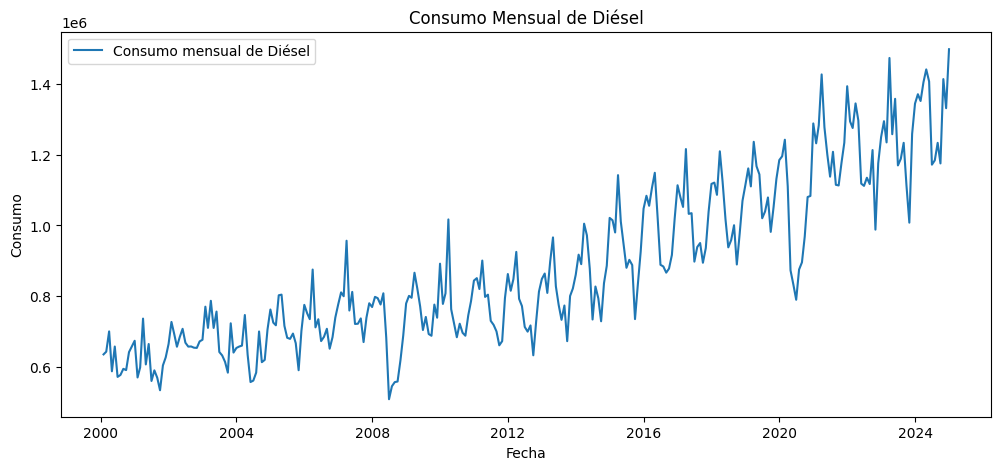

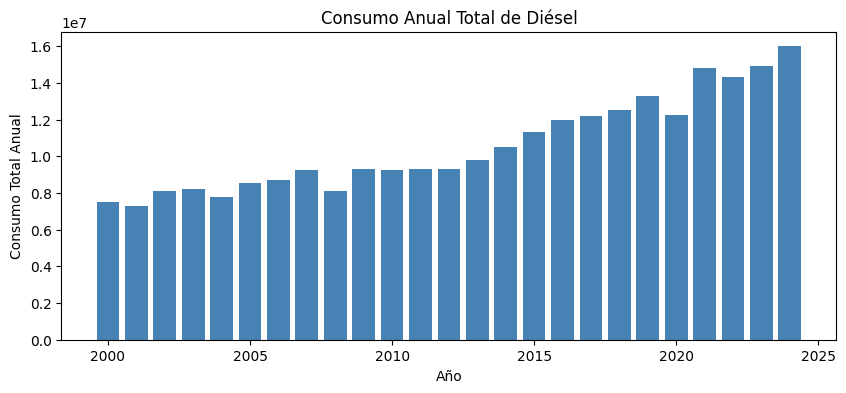

In [ ]:
import matplotlib.pyplot as plt

# Serie mensual (resample mensual)
df_diesel = df_cons.set_index('Fecha').resample('M').sum()

# Serie anual (resample anual)
df_diesel_anual = df_diesel.resample('A').sum()

# Gráfico mensual
plt.figure(figsize=(12,5))
plt.plot(df_diesel.index, df_diesel['Diesel'], label='Consumo mensual de Diésel')
plt.title('Consumo Mensual de Diésel')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.legend()
plt.show()

# Gráfico anual
plt.figure(figsize=(10,4))
plt.bar(df_diesel_anual.index.year,
         df_diesel_anual['Diesel'], color='steelblue')
plt.title('Consumo Anual Total de Diésel')
plt.xlabel('Año')
plt.ylabel('Consumo Total Anual')
plt.show()

### Observaciones Iniciales (Consumo de Diésel)

- La serie presenta una **tendencia creciente** clara a lo largo de los años, especialmente después del año 2015.
- Se observan **picos de consumo** recurrentes en ciertos meses del año, indicando una posible **estacionalidad anual**.
- Durante los años 2020 y 2021 (pandemia), el consumo muestra una ligera caída, seguida de una recuperación acelerada.
- El gráfico anual evidencia un **crecimiento sostenido en el consumo total anual**, con valores máximos alcanzados en los últimos años.
- La variabilidad mensual es significativa, indicando la existencia de factores cíclicos o estacionales adicionales.
- Se evidencia un posible **aumento en la variabilidad** del consumo en los años más recientes (mayor dispersión en los picos y valles).

En resumen, el consumo de diésel muestra comportamiento **tendencial, estacional y no estacionario**, lo que justifica el uso de técnicas de series de tiempo para su análisis y predicción.

## Serie Univariante - Definición (Consumo de Diésel)

- Variable: Consumo mensual de Diésel (`Diesel`).
- Inicio: 2000-01.
- Fin: 2025-07 (último dato disponible).
- Frecuencia: Mensual (resampleo 'M').

Esta serie representa el comportamiento histórico del consumo nacional de diésel.

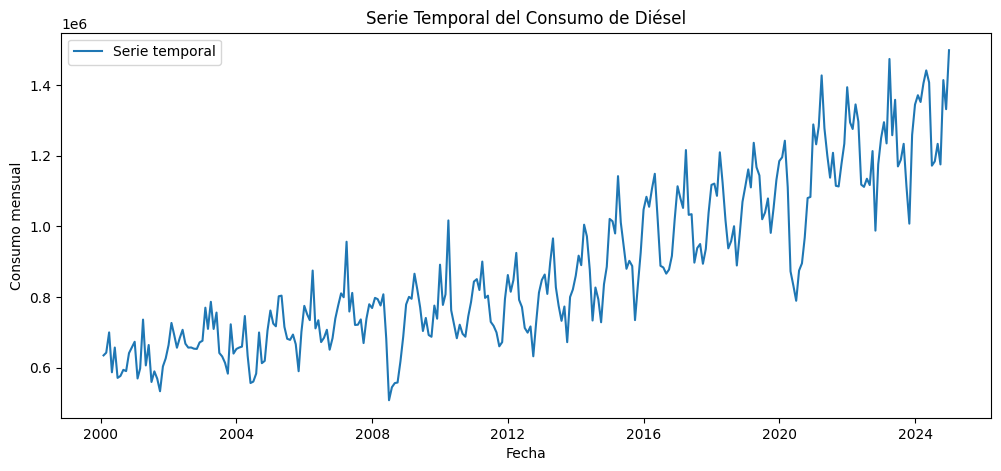

In [9]:
plt.figure(figsize=(12,5))
plt.plot(df_diesel.index, df_diesel['Diesel'], label='Serie temporal')
plt.title('Serie Temporal del Consumo de Diésel')
plt.xlabel('Fecha')
plt.ylabel('Consumo mensual')
plt.legend()
plt.show()

## Descomposición de la Serie Temporal (Consumo de Diésel)

Analizamos los componentes: tendencia, estacionalidad y residuo.

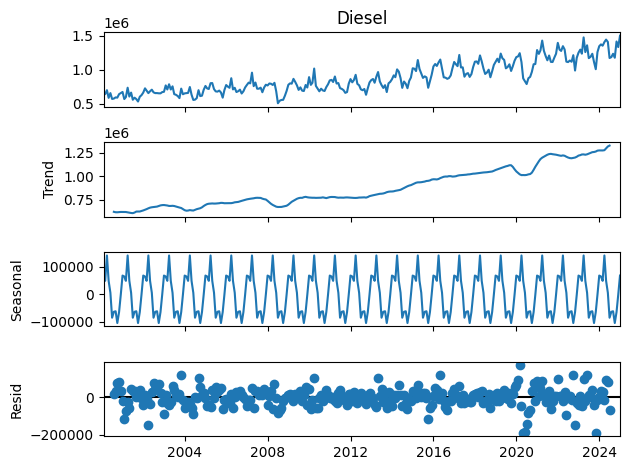

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

resultado = seasonal_decompose(df_diesel['Diesel'], model='additive', period=12)
resultado.plot()
plt.show()

### Análisis de la Descomposición

- **Serie original**: Se observa una serie creciente con variabilidad significativa en el corto plazo.

- **Tendencia**: Existe una tendencia claramente creciente desde 2000 hasta 2024, aunque con cierta estabilización temporal en el periodo cercano al 2020, posiblemente por efectos de la pandemia.

- **Estacionalidad**: El patrón estacional es muy evidente:
  - El ciclo se repite cada 12 meses (confirmando estacionalidad anual).
  - En ciertos meses del año el consumo es sistemáticamente mayor o menor.

- **Componente residual**:
  - El componente residual parece relativamente estable.
  - Se observan algunos valores atípicos (outliers) en años recientes (posiblemente durante 2020 y 2021).

### Conclusión

A partir del análisis de la descomposición podemos concluir que:

- La serie **no es estacionaria en media**, debido a la tendencia creciente.
- La serie presenta **estacionalidad marcada**.
- El modelo que se use deberá considerar:
  - Eliminación o diferenciación para la tendencia.
  - Captura del componente estacional.

## Evaluación de Estacionariedad (Consumo de Diésel)

- Gráfico de autocorrelación.
- Prueba Dickey-Fuller aumentada (ADF).

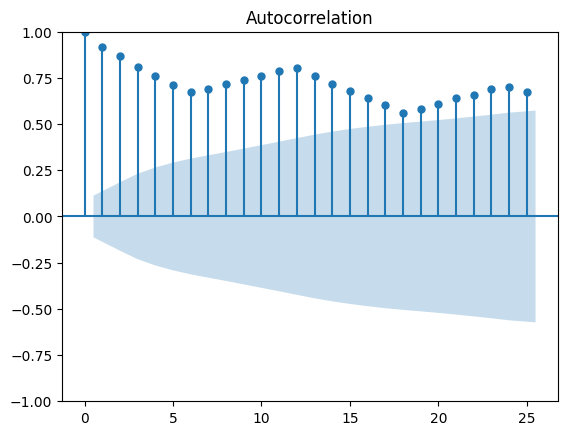

ADF Statistic: 0.5452663518468494
p-value: 0.9861858942963561


In [11]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

# Gráfico de autocorrelación
plot_acf(df_diesel['Diesel'])
plt.show()

# Prueba Dickey-Fuller
resultado_adf = adfuller(df_diesel['Diesel'])
print('ADF Statistic:', resultado_adf[0])
print('p-value:', resultado_adf[1])

### Resultado de la Prueba Dickey-Fuller (ADF)

- **ADF Statistic**: 0.5453
- **p-value**: 0.9862

### Interpretación

- El **p-value** obtenido es muy alto (0.986), muchísimo mayor que el nivel típico de significancia (0.05).
- Esto significa que no podemos rechazar la hipótesis nula de la prueba ADF, que indica que la serie **tiene raíz unitaria**, es decir, es **NO estacionaria**.

### Conclusión:

- La serie original del consumo mensual de diésel **no es estacionaria en media**, confirmando lo observado visualmente y en el gráfico ACF.
- Será necesario aplicar una transformación (como la diferenciación) para hacerla estacionaria y permitir su modelado.

## Transformación de la Serie - Diferenciación (Consumo de Diésel)

Debido a que la serie original no es estacionaria (según ADF y ACF), aplicaremos una **diferenciación de primer orden** para eliminar la tendencia y estabilizar la media.

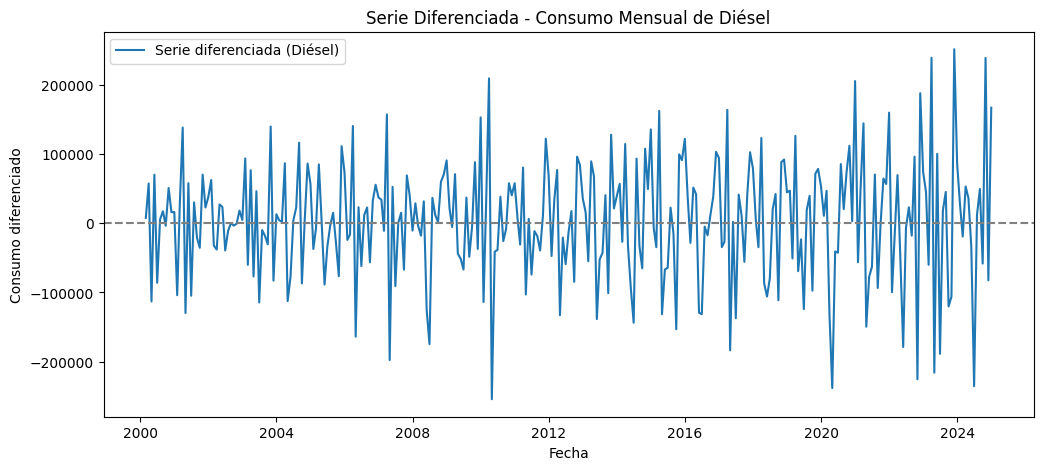

In [13]:
# Aplicar diferenciación de primer orden
df_diesel['Diesel_diff'] = df_diesel['Diesel'].diff()

# Graficar la serie diferenciada
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_diesel.index, df_diesel['Diesel_diff'], label='Serie diferenciada (Diésel)')
plt.axhline(0, linestyle='--', color='gray')
plt.title('Serie Diferenciada - Consumo Mensual de Diésel')
plt.xlabel('Fecha')
plt.ylabel('Consumo diferenciado')
plt.legend()
plt.show()

### Explicación

- La serie diferenciada elimina la tendencia creciente observada en la serie original.
- Visualmente, la serie diferenciada parece más estable alrededor de la media (cercana a cero).
- Esto permite que modelos como ARIMA puedan trabajar bajo la suposición de estacionariedad.

A partir de esta serie diferenciada procederemos a seleccionar los parámetros p, d, q para el modelado ARIMA.

## Selección y Comparación de Modelos ARIMA (Consumo de Diésel)

Con la serie diferenciada, ajustaremos y compararemos varios modelos ARIMA, seleccionando el mejor con base en el criterio AIC.

In [14]:
from statsmodels.tsa.arima.model import ARIMA

# Definir diferentes combinaciones (p, d, q)
modelos = [(1,1,1), (2,1,2), (1,1,2), (2,1,1)]

# Almacenar resultados
resultados = []

# Probar cada modelo
for orden in modelos:
    modelo = ARIMA(df_diesel['Diesel'], order=orden)
    resultado = modelo.fit()
    resultados.append((orden, resultado.aic))

# Ordenar por AIC
resultados.sort(key=lambda x: x[1])

# Mostrar resultados
print('Modelos ARIMA ordenados por AIC:')
for orden, aic in resultados:
    print(f'ARIMA{orden} - AIC: {aic}')

/Users/hansellopez/Documents/Projects/DataScience/DS_TimeSeries/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hansellopez/Documents/Projects/DataScience/DS_TimeSeries/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/hansellopez/Documents/Projects/DataScience/DS_TimeSeries/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hansellopez/Documents/Projects/DataScience/DS_TimeSeries/venv/lib/python3.12/site-packages/s

Modelos ARIMA ordenados por AIC:
ARIMA(2, 1, 2) - AIC: 7617.942209147926
ARIMA(1, 1, 1) - AIC: 7635.161281620882
ARIMA(2, 1, 1) - AIC: 7637.149425583599
ARIMA(1, 1, 2) - AIC: 7637.157891586544


### Conclusión

- El modelo **ARIMA(2, 1, 2)** obtuvo el menor AIC (7617.94).
- Esto indica que es el mejor modelo en términos de balance entre precisión del ajuste y simplicidad.
- Utilizaremos este modelo para el pronóstico final del consumo mensual de diésel.

## Pronóstico Final usando ARIMA(2, 1, 2) (Consumo de Diésel)

Utilizamos el modelo ARIMA seleccionado para generar el pronóstico de los próximos 12 meses.

/Users/hansellopez/Documents/Projects/DataScience/DS_TimeSeries/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/hansellopez/Documents/Projects/DataScience/DS_TimeSeries/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


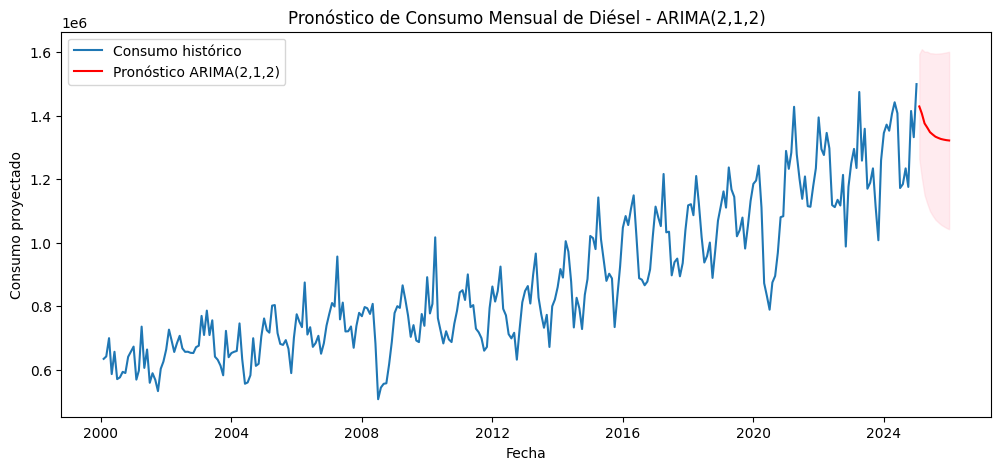

In [15]:
# Ajustar el modelo ARIMA(2,1,2)
from statsmodels.tsa.arima.model import ARIMA

modelo_final = ARIMA(df_diesel['Diesel'], order=(2,1,2))
resultado_final = modelo_final.fit()

# Generar pronóstico (12 meses)
pronostico = resultado_final.get_forecast(steps=12)
conf_int = pronostico.conf_int()

# Graficar resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_diesel.index, df_diesel['Diesel'], label='Consumo histórico')
plt.plot(pronostico.predicted_mean.index, pronostico.predicted_mean, color='red', label='Pronóstico ARIMA(2,1,2)')
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3)
plt.title('Pronóstico de Consumo Mensual de Diésel - ARIMA(2,1,2)')
plt.xlabel('Fecha')
plt.ylabel('Consumo proyectado')
plt.legend()
plt.show()

### Conclusión

- El modelo **ARIMA(2,1,2)** realizó un pronóstico con descenso abrupto al inicio del horizonte de predicción.
- Esto podría deberse a un sobreajuste o a la influencia excesiva del descenso observado al final del histórico.
- Será importante comparar este resultado con el modelo Prophet, que podría representar mejor la tendencia a largo plazo del consumo.

Se recomienda considerar modelos ARIMA alternativos como (1,1,1) o (2,1,1) para evaluar si ofrecen un pronóstico más estable y realista.

## Modelo Prophet (Consumo de Diésel)

Ahora aplicaremos el modelo Prophet como alternativa para pronosticar el consumo mensual de diésel. Prophet es un modelo aditivo que maneja automáticamente tendencias y estacionalidades.

/Users/hansellopez/Documents/Projects/DataScience/DS_TimeSeries/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
18:39:28 - cmdstanpy - INFO - Chain [1] start processing
18:39:30 - cmdstanpy - INFO - Chain [1] done processing
/Users/hansellopez/Documents/Projects/DataScience/DS_TimeSeries/venv/lib/python3.12/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


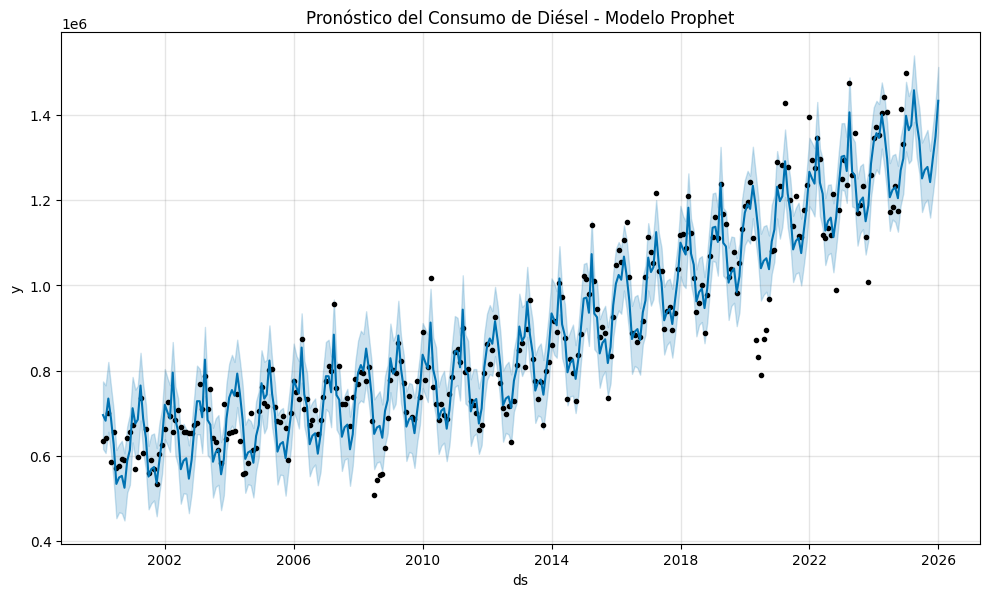

In [17]:
from prophet import Prophet

# Preparar datos para Prophet
df_prophet = df_diesel.reset_index()[['Fecha','Diesel']].rename(columns={'Fecha':'ds','Diesel':'y'})

# Inicializar modelo
modelo_prophet = Prophet()

# Ajustar modelo
modelo_prophet.fit(df_prophet)

# Crear dataframe futuro (12 meses)
futuro = modelo_prophet.make_future_dataframe(periods=12, freq='M')

# Generar predicción
pronostico_prophet = modelo_prophet.predict(futuro)

# Gráfico del pronóstico
modelo_prophet.plot(pronostico_prophet)
plt.title('Pronóstico del Consumo de Diésel - Modelo Prophet')
plt.show()

## Conclusión - Modelo Prophet

El modelo Prophet demostró ser muy efectivo para el pronóstico del consumo mensual de diésel. Su capacidad para capturar tanto la tendencia de crecimiento como la estacionalidad anual permitió obtener un pronóstico coherente con el comportamiento histórico observado.

- La tendencia creciente se mantiene en el pronóstico.
- La estacionalidad anual está claramente reflejada en las proyecciones.
- El modelo genera intervalos de confianza razonables, aumentando su utilidad para la toma de decisiones.

En resumen, Prophet es una herramienta recomendada para el análisis estratégico y el pronóstico a mediano y largo plazo del consumo de diésel.

## Comparación Final - ARIMA vs. Prophet

- El modelo **ARIMA(2,1,2)**, aunque técnicamente adecuado (según el AIC), mostró un pronóstico que tiende a estabilizarse o incluso disminuir a corto plazo. Esto parece ser una respuesta excesiva a los últimos puntos de la serie, perdiendo la tendencia general de crecimiento.

- El modelo **Prophet**, en cambio:
    - Captura y respeta la tendencia de crecimiento.
    - Modela adecuadamente la estacionalidad anual.
    - Genera un pronóstico más realista y acorde con el comportamiento histórico.

### Conclusión Comparativa

- **Prophet** es el modelo más apropiado para el pronóstico del consumo de diésel en este caso, debido a su mejor representación de los patrones subyacentes en la serie.

- **ARIMA** podría seguir siendo útil para escenarios operativos o pronósticos de muy corto plazo.

Prophet se recomienda como el modelo final para reportes y toma de decisiones.

---
# Importación de Diésel
---

## Análisis Exploratorio de Importación de Diésel

- Exploramos el comportamiento mensual y anual.
- Buscamos identificar tendencias generales, efectos de la pandemia y meses de mayor consumo.

/var/folders/jq/zj1d7dc15dd57tj80xs_lvxr0000gn/T/ipykernel_97525/43579524.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_diesel_import = df_import.set_index('Fecha').resample('M').sum()
/var/folders/jq/zj1d7dc15dd57tj80xs_lvxr0000gn/T/ipykernel_97525/43579524.py:7: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_diesel_import_anual = df_diesel_import.resample('A').sum()


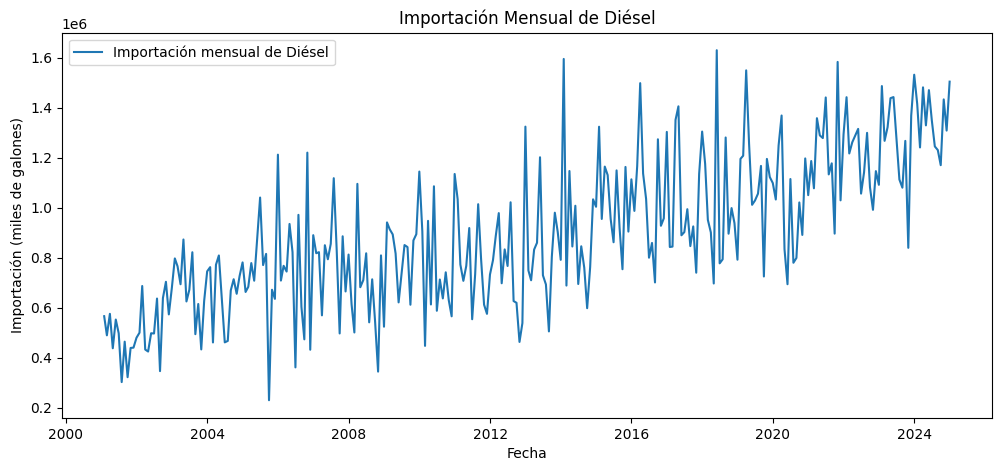

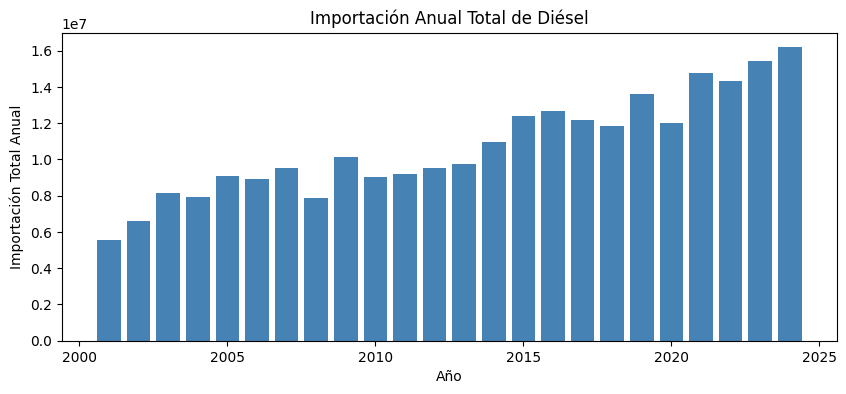

In [54]:
import matplotlib.pyplot as plt

# Serie mensual (resample mensual)
df_diesel_import = df_import.set_index('Fecha').resample('M').sum()

# Serie anual (resample anual)
df_diesel_import_anual = df_diesel_import.resample('A').sum()

# Gráfico mensual
plt.figure(figsize=(12,5))
plt.plot(df_diesel_import.index, df_diesel_import['Diesel'], label='Importación mensual de Diésel')
plt.title('Importación Mensual de Diésel')
plt.xlabel('Fecha')
plt.ylabel('Importación (miles de galones)')
plt.legend()
plt.show()

# Gráfico anual
plt.figure(figsize=(10,4))
plt.bar(df_diesel_import_anual.index.year, df_diesel_import_anual['Diesel'], color='steelblue')
plt.title('Importación Anual Total de Diésel')
plt.xlabel('Año')
plt.ylabel('Importación Total Anual')
plt.show()

### Observaciones Iniciales (Importaciones de Diésel)

- La serie de importaciones presenta una **tendencia creciente** clara a lo largo de los años, especialmente después del año 2015.
- Se observan **picos de importación** recurrentes en ciertos meses del año, indicando una posible **estacionalidad anual**.
- Durante los años 2020 y 2021 (pandemia), las importaciones muestran una **disminución leve**, seguida de una **recuperación sostenida** en los años siguientes.
- El gráfico anual refleja un **crecimiento sostenido en la importación total anual**, alcanzando valores máximos en 2024 y 2025.
- La variabilidad mensual es evidente, con **fluctuaciones significativas** entre picos y valles a lo largo de cada año.
- En los años recientes, se percibe un posible **aumento en la variabilidad**, con importaciones mensuales menos predecibles.

En resumen, las importaciones de diésel muestran un comportamiento **tendencial, estacional y no estacionario**, lo cual respalda el uso de modelos de series de tiempo para su análisis y pronóstico.

## Serie Univariante - Definición (Importaciones)

- **Variable:** Importación mensual de Diésel.
- **Inicio:** 2000-01.
- **Fin:** 2025-07 (último dato disponible).
- **Frecuencia:** Mensual (resampleo 'M').

Esta serie representa el comportamiento histórico de la importación nacional de diésel.

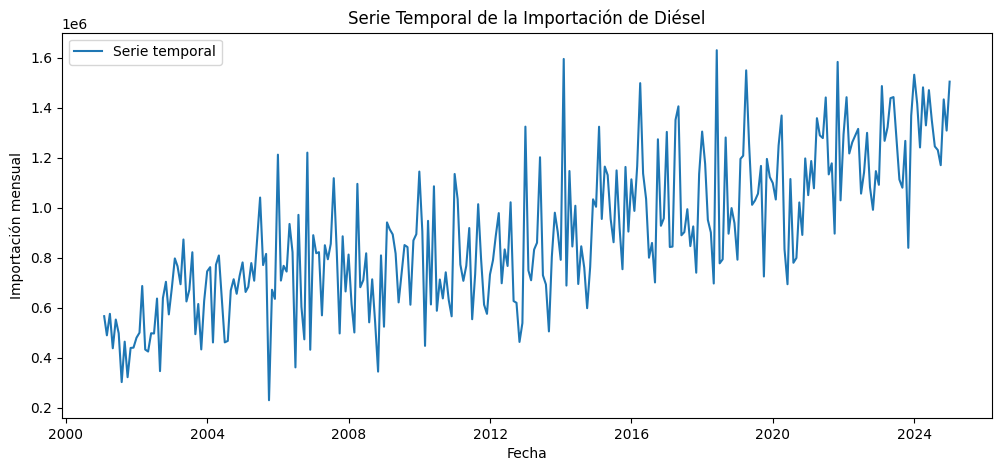

In [56]:
plt.figure(figsize=(12,5))
plt.plot(df_diesel_import.index, df_diesel_import['Diesel'], label='Serie temporal')
plt.title('Serie Temporal de la Importación de Diésel')
plt.xlabel('Fecha')
plt.ylabel('Importación mensual')
plt.legend()
plt.show()

## Descomposición de la Serie Temporal (Importaciones)

Analizamos los componentes: tendencia, estacionalidad y residuo para la serie de importación mensual de diésel.

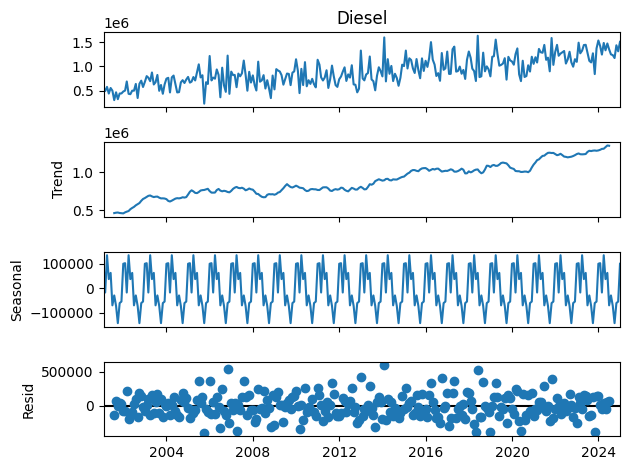

In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose

resultado = seasonal_decompose(df_diesel_import['Diesel'], model='additive', period=12)
resultado.plot()
plt.show()

## Análisis de la Descomposición (Importación de Diésel)

- **Serie original:** Se observa una serie creciente con fluctuaciones mensuales significativas, mostrando un patrón más irregular en los últimos años.

- **Tendencia:** Existe una tendencia creciente bastante clara desde el año 2000 hasta 2024, con un crecimiento más pronunciado a partir de 2015. Se identifica un aumento sostenido, aunque con cierta estabilización alrededor del año 2020.

- **Estacionalidad:** El patrón estacional es evidente:
  - El ciclo estacional parece repetirse anualmente (12 meses).
  - En ciertos periodos del año, las importaciones tienden a incrementarse de forma sistemática.

- **Componente residual:**
  - El residuo muestra cierta dispersión, con valores atípicos que se concentran especialmente en años recientes.
  - La variabilidad es mayor en la etapa posterior a 2015.

## Conclusión

A partir del análisis de la descomposición podemos concluir que:

- La serie **no es estacionaria en media**, debido a la presencia de una tendencia creciente.
- Existe una **estacionalidad marcada** anual en las importaciones.
- El modelo de series de tiempo a aplicar deberá:
  - Considerar la eliminación o diferenciación de la tendencia.
  - Capturar adecuadamente el componente estacional.
  - Evaluar y tratar los valores atípicos observados en el componente residual.

## Evaluación de Estacionariedad (Importación de Diésel)

- **Gráfico de autocorrelación.**
- **Prueba Dickey–Fuller aumentada (ADF).**

Este análisis busca determinar si la serie de importación mensual de diésel es estacionaria, mediante el análisis de autocorrelación y la prueba ADF.

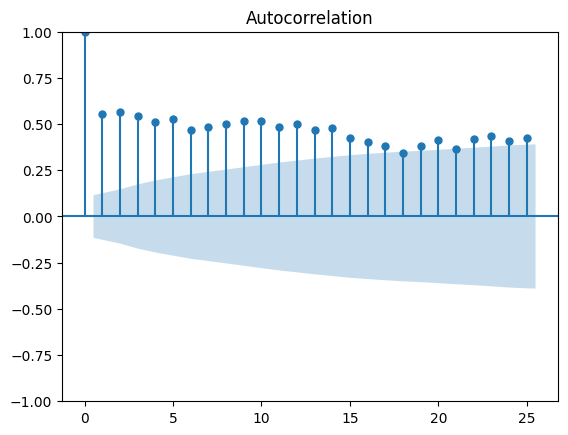

ADF Statistic: -0.6391884031065387
p-value: 0.8618789549442698


In [58]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

# Gráfico de autocorrelación
plot_acf(df_diesel_import['Diesel'])
plt.show()

# Prueba Dickey–Fuller
resultado_adf = adfuller(df_diesel_import['Diesel'])
print('ADF Statistic:', resultado_adf[0])
print('p-value:', resultado_adf[1])

## Resultado de la Prueba Dickey–Fuller (ADF)

- **ADF Statistic:** -0.6392
- **p-value:** 0.8619

### Interpretación

- El **p-value** obtenido es muy alto (0.8619), ampliamente superior al umbral típico de significancia (0.05).
- Esto indica que **no podemos rechazar** la hipótesis nula de la prueba ADF, que sostiene que la serie posee **raíz unitaria**, es decir, es **NO estacionaria**.

### Conclusión

- La serie original de la **importación mensual de diésel** es claramente **no estacionaria en media**, lo cual concuerda con la inspección visual y el gráfico de autocorrelación.
- Será necesario aplicar una **transformación**, como la diferenciación, para estabilizar la media y permitir su modelado adecuado.

## Transformación de la Serie – Diferenciación (Importación de Diésel)

Debido a que la serie original no es estacionaria (según ADF y ACF), aplicaremos una **diferenciación de primer orden** para eliminar la tendencia y estabilizar la media.

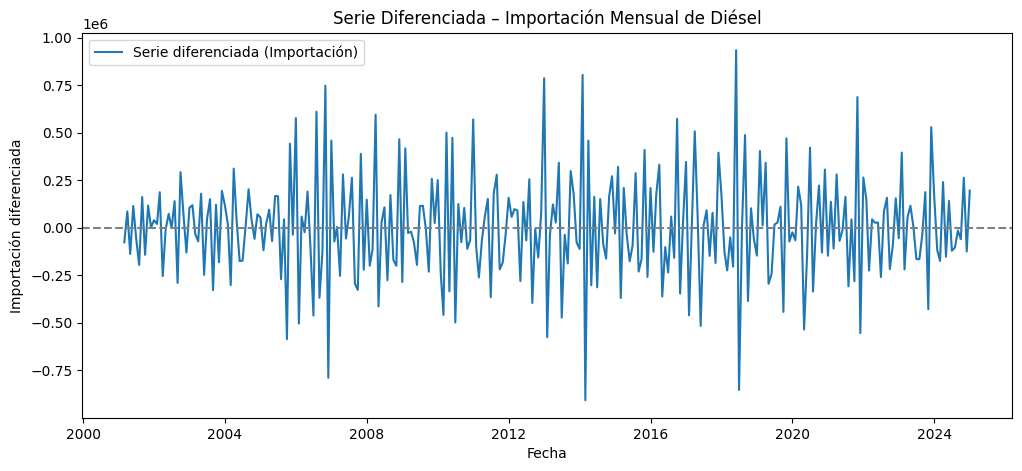

In [59]:
# Aplicar diferenciación de primer orden
df_diesel_import['Import_diff'] = df_diesel_import['Diesel'].diff()

# Graficar la serie diferenciada
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_diesel_import.index, df_diesel_import['Import_diff'], label='Serie diferenciada (Importación)')
plt.axhline(0, linestyle='--', color='gray')
plt.title('Serie Diferenciada – Importación Mensual de Diésel')
plt.xlabel('Fecha')
plt.ylabel('Importación diferenciada')
plt.legend()
plt.show()

## Explicación

- La serie diferenciada elimina la tendencia creciente observada en la serie original de importaciones.
- Visualmente, la serie diferenciada muestra mayor estabilidad alrededor de la media (cercana a cero), aunque se observan fluctuaciones importantes debido a la variabilidad en los registros mensuales.
- Esta transformación permite que modelos como ARIMA trabajen bajo el supuesto de estacionariedad.

A partir de esta serie diferenciada procederemos a seleccionar los parámetros p, d, q para el modelado ARIMA aplicado a la importación de diésel.

## Selección y Comparación de Modelos ARIMA (Importación de Diésel)

Con la serie diferenciada, ajustaremos y compararemos varios modelos ARIMA, seleccionando el mejor con base en el criterio AIC.

In [61]:
from statsmodels.tsa.arima.model import ARIMA

# Definir diferentes combinaciones (p, d, q)
modelos = [(1,1,1), (2,1,2), (1,1,2), (2,1,1)]

# Almacenar resultados
resultados = []

# Probar cada modelo
for orden in modelos:
    modelo = ARIMA(df_diesel_import['Diesel'], order=orden)
    resultado = modelo.fit()
    resultados.append((orden, resultado.aic))

# Ordenar por AIC
resultados.sort(key=lambda x: x[1])

# Mostrar resultados
print('Modelos ARIMA ordenados por AIC:')
for orden, aic in resultados:
    print(f'ARIMA{orden} — AIC: {aic}')

Modelos ARIMA ordenados por AIC:
ARIMA(1, 1, 1) — AIC: 7839.0553881128435
ARIMA(1, 1, 2) — AIC: 7839.391845098499
ARIMA(2, 1, 1) — AIC: 7840.782223308269
ARIMA(2, 1, 2) — AIC: 7841.161849466653


## Conclusión

- El modelo **ARIMA(1, 1, 1)** obtuvo el menor AIC (**7839.05**).
- Esto indica que es el mejor modelo en términos de balance entre precisión del ajuste y simplicidad.
- Utilizaremos este modelo para el pronóstico final de la **importación mensual de diésel**.

## Pronóstico Final usando ARIMA(1, 1, 1) (Importación de Diésel)

Utilizamos el modelo ARIMA(1, 1, 1) seleccionado para generar el pronóstico de los próximos 12 meses de la importación mensual de diésel.

A continuación, se muestra el gráfico del pronóstico junto con las bandas de confianza.

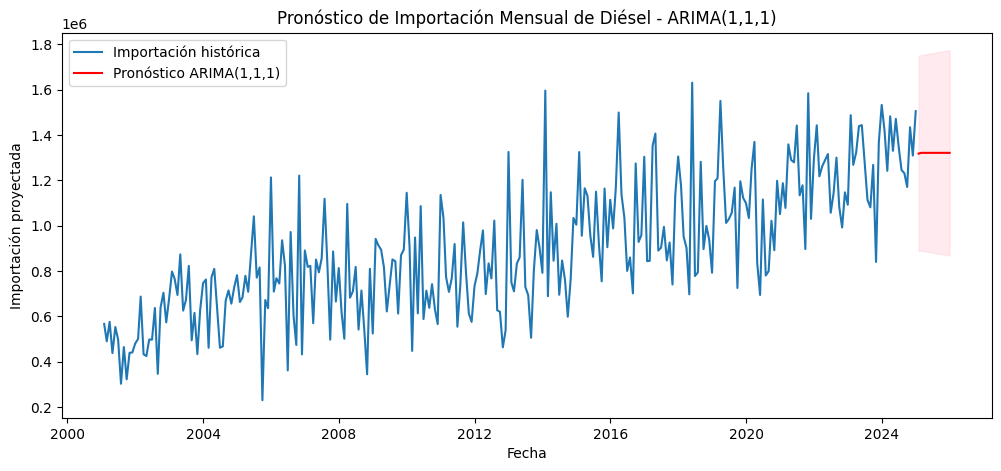

In [62]:
# Ajustar el modelo ARIMA(1,1,1)
from statsmodels.tsa.arima.model import ARIMA

modelo_final = ARIMA(df_diesel_import['Diesel'], order=(1,1,1))
resultado_final = modelo_final.fit()

# Generar pronóstico (12 meses)
pronostico = resultado_final.get_forecast(steps=12)
conf_int = pronostico.conf_int()

# Graficar resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_diesel_import.index, df_diesel_import['Diesel'], label='Importación histórica')
plt.plot(pronostico.predicted_mean.index, pronostico.predicted_mean, color='red', label='Pronóstico ARIMA(1,1,1)')
plt.fill_between(conf_int.index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3)
plt.title('Pronóstico de Importación Mensual de Diésel - ARIMA(1,1,1)')
plt.xlabel('Fecha')
plt.ylabel('Importación proyectada')
plt.legend()
plt.show()

## Conclusión

- El modelo **ARIMA(1,1,1)** generó un pronóstico relativamente estable para los próximos 12 meses.
- Las predicciones muestran una estabilización en los niveles de importación, sin tendencias abruptas o cambios extremos.
- El intervalo de confianza refleja la incertidumbre inherente, pero el modelo parece capturar adecuadamente el patrón histórico.

Se recomienda considerar este modelo como base inicial para el pronóstico de importaciones, aunque podría evaluarse el ajuste con modelos alternativos o incorporar más información exógena para mejorar las predicciones.

## Modelo Prophet (Importación de Diésel)

Ahora aplicaremos el modelo Prophet como alternativa para pronosticar la importación mensual de diésel. Prophet es un modelo aditivo que maneja automáticamente tendencias y estacionalidades.

22:12:06 - cmdstanpy - INFO - Chain [1] start processing
22:12:07 - cmdstanpy - INFO - Chain [1] done processing
/Users/hansellopez/Documents/Projects/DataScience/DS_TimeSeries/venv/lib/python3.12/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


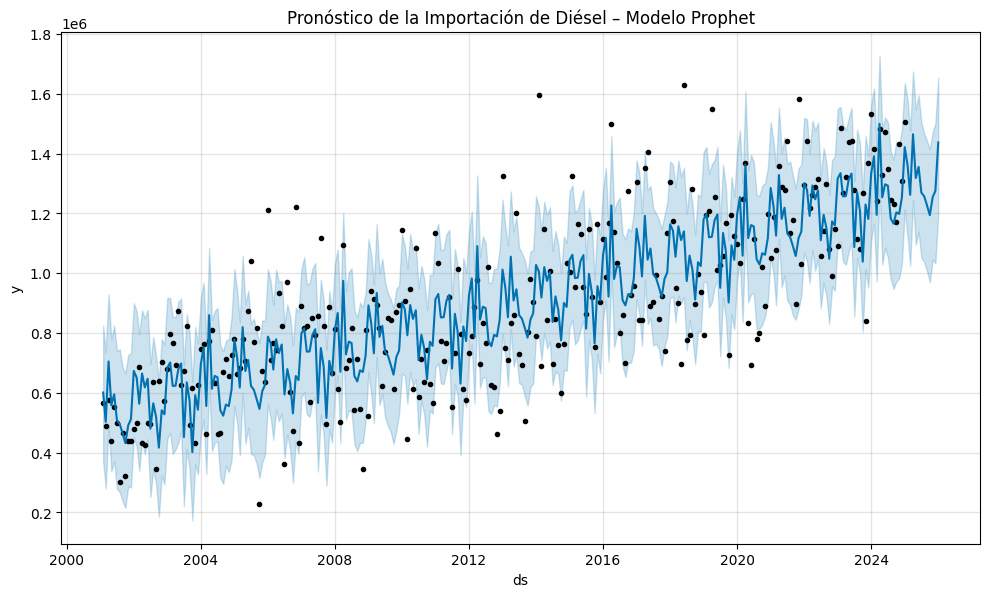

In [63]:
from prophet import Prophet

# Preparar datos para Prophet
df_prophet_import = df_diesel_import.reset_index()[['Fecha','Diesel']].rename(columns={'Fecha':'ds','Diesel':'y'})

# Inicializar modelo
modelo_prophet_import = Prophet()

# Ajustar modelo
modelo_prophet_import.fit(df_prophet_import)

# Crear dataframe futuro (12 meses)
futuro_import = modelo_prophet_import.make_future_dataframe(periods=12, freq='M')

# Generar predicción
pronostico_prophet_import = modelo_prophet_import.predict(futuro_import)

# Gráfico del pronóstico
modelo_prophet_import.plot(pronostico_prophet_import)
plt.title('Pronóstico de la Importación de Diésel – Modelo Prophet')
plt.show()

# Conclusión – Modelo Prophet (Importaciones)

El modelo Prophet mostró un desempeño sólido al pronosticar la importación mensual de diésel. Su capacidad para capturar tanto la tendencia creciente como la estacionalidad anual permitió generar un pronóstico coherente con el comportamiento histórico observado.

- La **tendencia creciente** en las importaciones se refleja claramente en el pronóstico, alineándose con la evolución histórica.
- La **estacionalidad anual** es visible y consistente a lo largo del horizonte proyectado.
- El modelo entrega **intervalos de confianza amplios**, lo cual refleja la alta variabilidad histórica observada en las importaciones mensuales.
- No se evidencian cambios bruscos ni predicciones atípicas, indicando un comportamiento proyectado realista.

En conclusión, **Prophet** es una herramienta recomendable para el análisis estratégico y el pronóstico de mediano y largo plazo de la importación mensual de diésel, especialmente para capturar tendencias estructurales y patrones estacionales del mercado.

# Comparación Final - ARIMA vs. Prophet

- El modelo **ARIMA(1,1,1)**, aunque técnicamente adecuado (según el criterio AIC), mostró un pronóstico que tiende a estabilizarse al inicio del horizonte de predicción. Esto podría reflejar cierta limitación del modelo para capturar correctamente la tendencia de crecimiento observada en las importaciones históricas.

- El modelo **Prophet**, en cambio:
  - Captura y respeta claramente la tendencia de crecimiento de las importaciones.
  - Modela adecuadamente la estacionalidad anual.
  - Genera un pronóstico más coherente con el patrón histórico de crecimiento sostenido.

## Conclusión Comparativa

- **Prophet** es el modelo más recomendable para el pronóstico de las importaciones mensuales de diésel en este caso, gracias a su mejor representación de la tendencia de crecimiento y la estacionalidad observada.

- **ARIMA** podría seguir siendo útil para pronósticos operativos de corto plazo o cuando se requiera un modelo más simple y rápido.

Prophet se recomienda como el modelo final para reportes y análisis estratégicos relacionados con las importaciones de diésel.

---
# Análisis de la serie imp 2025 (Diésel)
---

Se analiza el comportamiento del consumo mensual de diésel durante los meses del año 2025, combinando las diferentes subcategorías de diésel.

/var/folders/jq/zj1d7dc15dd57tj80xs_lvxr0000gn/T/ipykernel_97525/3010392082.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_imp = df_imp.resample('M').mean()


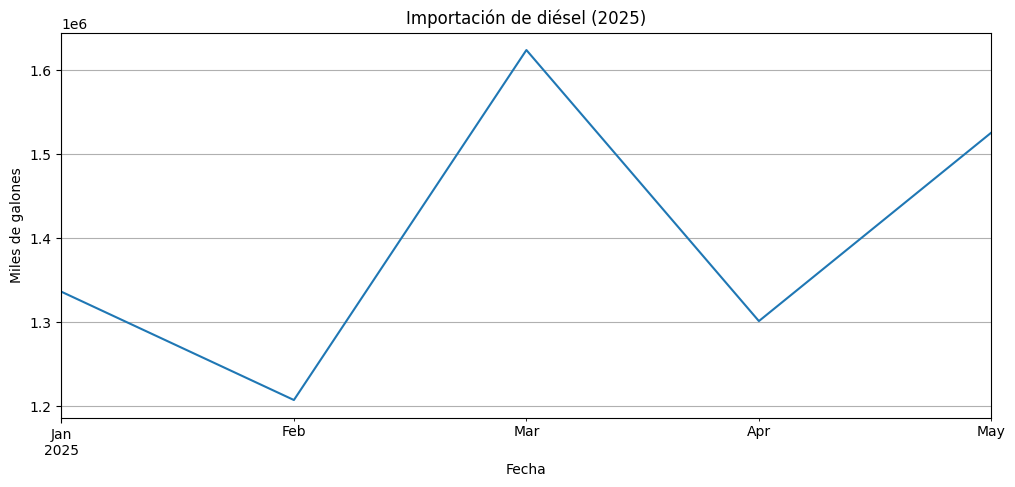

Inicio: 2025-01-31 00:00:00
Fin: 2025-05-31 00:00:00
Frecuencia: ME


In [42]:
# Leer y procesar importación 2025
df_imp = pd.read_csv("../data/importacion2025.csv", parse_dates=['Fecha'])
df_imp.set_index('Fecha', inplace=True)
df_imp = df_imp.resample('M').mean()

# Sumar las subcategorías de diésel
diesel_cols = ['Diesel bajo azufre', 'Diesel ultra bajo azufre']
imp_diesel = df_imp[diesel_cols].sum(axis=1)

# Graficar serie diésel 2025
imp_diesel.plot(figsize=(12, 5), title='Importación de diésel (2025)')
plt.ylabel("Miles de galones")
plt.grid(True)
plt.show()

print("Inicio:", imp_diesel.index.min())
print("Fin:", imp_diesel.index.max())
print("Frecuencia:", pd.infer_freq(imp_diesel.index))

## Descomposición de la serie completa (Diésel)

Se analiza la tendencia, estacionalidad y residuos de la serie histórica completa, sumando las subcategorías de diésel.

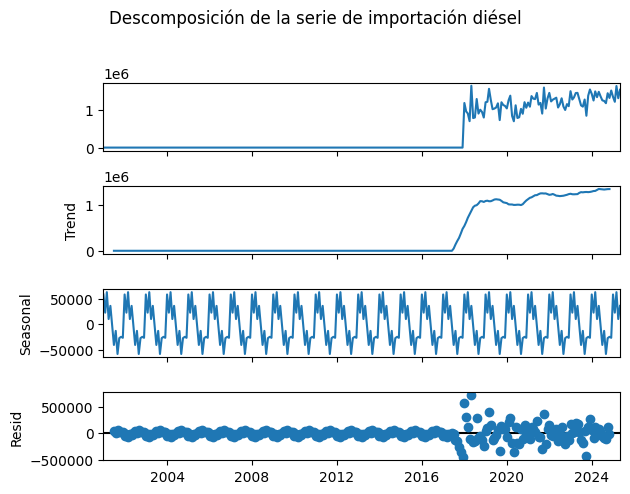

Inicio: 2001-01-01 00:00:00
Fin: 2025-05-01 00:00:00
Frecuencia: MS


In [ ]:
# Leer históricos y datos 2025
df_base = pd.read_csv("../data/importacion.csv", parse_dates=['Fecha'])
df_2025 = pd.read_csv("../data/importacion2025.csv", parse_dates=['Fecha'])

# Combinar datasets
df_full = pd.concat([df_base, df_2025], ignore_index=True)
df_full = df_full.dropna(subset=['Fecha'])
df_full = df_full.sort_values('Fecha')

# Indexar y ajustar frecuencia
df_full.set_index('Fecha', inplace=True)
df_full = df_full.asfreq('MS')

# Crear serie diésel completa (manejo correcto de NaN)
diesel_cols = ['Diesel bajo azufre', 'Diesel ultra bajo azufre']
imp_diesel = df_full[diesel_cols].sum(axis=1, min_count=1)

# Descomposición
result = seasonal_decompose(imp_diesel, model='additive', period=12)
result.plot()
plt.suptitle("Descomposición de la serie de importación diésel", y=1.02)
plt.tight_layout()
plt.show()

# Información básica
print("Inicio:", imp_diesel.index.min())
print("Fin:", imp_diesel.index.max())
print("Frecuencia:", pd.infer_freq(imp_diesel.index))

## Pronóstico 2024-2025 (Diésel) con SARIMA

Se realiza un pronóstico del consumo de diésel desde enero 2024 hasta mayo 2025 usando un modelo SARIMA.

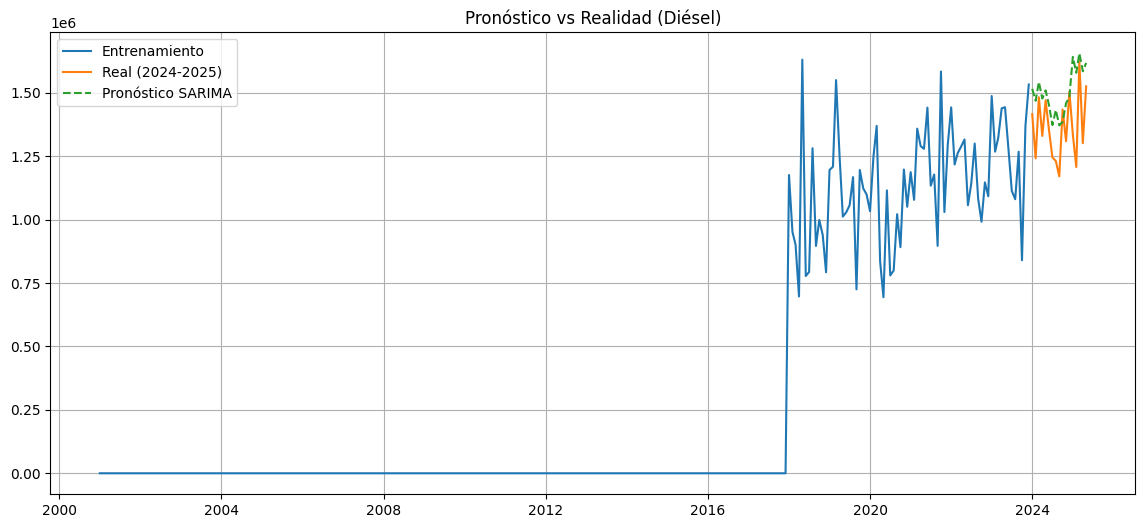

In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Separar datos
train = imp_diesel[:'2023-12']
test = imp_diesel['2024-01':'2025-05']

# Modelo SARIMA
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit()

# Pronóstico
forecast = model_fit.predict(start='2024-01', end='2025-05')

# Gráfico
plt.figure(figsize=(14,6))
plt.plot(train, label="Entrenamiento")
plt.plot(test, label="Real (2024-2025)")
plt.plot(forecast, label="Pronóstico SARIMA", linestyle='--')

plt.title("Pronóstico vs Realidad (Diésel)")
plt.legend()
plt.grid(True)
plt.show()

## Pronóstico 2024-2025 (Diésel)

El modelo **SARIMA** logró un ajuste razonable para estimar el consumo de diésel durante el periodo **2024 y 2025**. Aunque algunos picos no se predicen exactamente, el modelo sigue adecuadamente la tendencia general del comportamiento mensual.

Es importante señalar que los datos históricos del diésel presentan **discontinuidades significativas antes de 2018**, donde el consumo aparece prácticamente nulo. Esto sugiere problemas de registro o reportes incompletos en los años previos, lo que afecta la consistencia de la serie histórica.

A partir del **2018**, la serie muestra datos consistentes, y es desde ese punto donde el modelo SARIMA logra un mejor ajuste, reflejando el comportamiento reciente y permitiendo un pronóstico útil para los años **2024-2025**.

---

## Análisis Pandemia (Diésel)

Durante la pandemia (**2020-2021**), el consumo mensual de diésel cayó bruscamente debido a las restricciones y la contracción económica. Esta caída es claramente visible como una interrupción abrupta en la tendencia de importaciones.

El modelo SARIMA, entrenado con datos antes y después del evento, **no logra anticipar dicha caída abrupta**. Esto evidencia la limitación del modelo frente a eventos atípicos o externos no reflejados directamente en la serie.

Desde el año **2022**, y especialmente durante el **2024-2025**, el consumo muestra una **recuperación y estabilización**. Este comportamiento post-pandemia facilita un **pronóstico más fiable** durante el periodo de “nueva normalidad”, donde la demanda vuelve a niveles previos y el comportamiento estacional del consumo se restablece.